<a href="https://colab.research.google.com/github/ergintuncer/Sezen-aksu-ark-s-yazan-yapay-zeka-diyorum/blob/master/Sezen_Aksu_Lyrics_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Gerekli kütüphaneleri import edelim
import numpy as np
import pandas as pd
import sys 
from keras.models import Sequential
from keras.layers import LSTM, Activation, Flatten, Dropout, Dense, Embedding, TimeDistributed, CuDNNLSTM,BatchNormalization
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.utils import np_utils
from keras import optimizers
from sklearn.model_selection import train_test_split
from keras.callbacks import TensorBoard
from time import time
from google.colab import files

C:\Users\ergin\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [0]:
# verisetini yükleyelim
uploaded = files.upload()

In [0]:
# yüklenen verisetini seçelim
dataset = pd.read_csv('Sezen Aksu.csv', encoding = "utf_8")
dataset.head()

,Sanatçı Adı,Şarkı Id,Şarkı Adı,Şarkı Sözü,Satır No
0,Sezen Aksu,1,1945,Bin Dokuzyüz Kırkbeş,1
1,Sezen Aksu,1,1945,Gel asırlardan uzanda tut ellerimi sımsıcak,2
2,Sezen Aksu,1,1945,Yoksa bendeki çocukda böyle çaresiz kalacak,3
3,Sezen Aksu,1,1945,Öfke ile beslenen çocuklar yalnızdırlar,4
4,Sezen Aksu,1,1945,Ve ümitleri çiçeklerden acıları tarihlerden,5


In [0]:
def processFirstLine(lyrics, songID, songName, row):
    lyrics.append(row['Şarkı Sözü'] + '\n')
    songID.append(row['Şarkı Id'])
    songName.append(row['Şarkı Adı'])
    return lyrics,songID,songName
  
# Boş listeleri tanımlayalım (lyrics , songID , songName) 
lyrics = []
songID = []
songName = []

# songNumber verisetindeki şarkının sırasını belirtir.
songNumber = 1
# i veisetindeki şarkı sözünün sırasını belirtir.
i = 0
isFirstLine = True
# Her bir satırdaki verileri sırası ile birleştirelim.
for index,row in dataset.iterrows():
    if(songNumber == row['Şarkı Id']):
        if (isFirstLine):
            lyrics,songID,songName = processFirstLine(lyrics,songID,songName,row)
            isFirstLine = False
        else :
            # Eğer aynı şarkıdaysak birleştirmeye devam edelim  
            lyrics[i] +=  row['Şarkı Sözü'] + '\n'
    # Aynı şarkı için söz birleştirme işlemi bittiyse bir sonrarki şarkıya geç:   
    else :
        lyrics,songID,songName = processFirstLine(lyrics,songID,songName,row)
        songNumber = row['Şarkı Id']
        i+=1

In [0]:
# Sözleri .txt dosyasına kaydedelim
with open('lyricsText.txt', 'w',encoding="utf-8") as filehandle:  
    for listitem in lyrics:
        filehandle.write('%s\n' % listitem)

In [0]:
# yeni verisetini yükle ve tüm karakterleri küçük harfe dönüştür :
textFileName = 'lyricsText.txt'
raw_text = open(textFileName, encoding = 'UTF-8').read()
raw_text = raw_text.lower()

In [0]:
# her harfi int türünde dönüştürelim
chars = sorted(list(set(raw_text)))
int_chars = dict((i, c) for i, c in enumerate(chars))
chars_int = dict((i, c) for c, i in enumerate(chars))

In [0]:
n_chars = len(raw_text)
n_vocab = len(chars)
print('Toplam karakter sayısı :'  , n_chars) # number of all the characters in lyricsText.txt dosyasındaki tüm harf sayısı
print('Unique karakter sayısı : ', n_vocab) # farklı harakter sayısı

Toplam karakter sayısı : 340460
Unique karakter sayısı :  61


In [0]:
# verisetinin işlenmesi:
seq_len = 32
data_X = []
data_y = []
for i in range(0, n_chars - seq_len, 1):
    # Input Sequeance(Input olarak kullanılacak)
    seq_in  = raw_text[i:i+seq_len]
    # Output sequence (Target olarak kullanılacak)
    seq_out = raw_text[i + seq_len]
    # Input verisini data_X olarak saklayalım
    data_X.append([chars_int[char] for char in seq_in])
    # Target verilerini data_y olarak saklayalım
    data_y.append(chars_int[seq_out])
n_patterns = len(data_X)
print( 'Eğitim setindeki toplam veri sayısı : ', n_patterns)

Eğitim setindeki toplam veri sayısı :  340428


In [0]:
# data_x verisinin LSTM RNN' de işlenecek şekilde yeniden düzenlenmesi:
X = np.reshape(data_X , (n_patterns, seq_len, 1))
# verilerin normalize edilmesi:
X = X/ float(n_vocab)
# Target verisi için One hot encoding:
y = np_utils.to_categorical(data_y)

In [0]:
# eğitim ve test verilerini oluşturalım
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=64)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(306385, 32, 1) (306385, 61)
(34043, 32, 1) (34043, 61)


In [0]:
# modelin oluşturulması 
model = Sequential()

model.add(CuDNNLSTM(512, input_shape =(X_train.shape[1], X_train.shape[2]), return_sequences = True,name='input'))
model.add(BatchNormalization(name='BatchNorm'))
model.add(CuDNNLSTM(512, return_sequences=True, name='CuDNNLSTM'))
    
model.add(Flatten(name='Flatten'))

model.add(Dense(y.shape[1],name='FullyConnected'))
model.add(Activation('softmax',name='output'))

adam=optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)

model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (CuDNNLSTM)            (None, 32, 512)           1054720   
_________________________________________________________________
BatchNorm (BatchNormalizatio (None, 32, 512)           2048      
_________________________________________________________________
CuDNNLSTM (CuDNNLSTM)        (None, 32, 512)           2101248   
_________________________________________________________________
Flatten (Flatten)            (None, 16384)             0         
_________________________________________________________________
FullyConnected (Dense)       (None, 61)                999485    
_________________________________________________________________
output (Activation)          (None, 61)                0         
Total params: 4,157,501
Trainable params: 4,156,477
Non-trainable params: 1,024
______________________________________________________________

In [0]:
# Checkpoit oluşturalım :
checkpoint_name = 'Sezen-Aksu-Epoch_{epoch:02d}-Acc_{acc:.2f}-Val_Acc_{val_acc:.2f}.hdf5'
checkpoint = ModelCheckpoint(checkpoint_name, monitor='loss', verbose = 1, save_best_only = True, mode ='min')

#Modelin gelişimi grafiksel olarak görmek için tensorboar kullanalım
tensorboard = TensorBoard(log_dir="logs/{}".format(time()),
                          write_graph=False,
                          write_images=True,
                          batch_size = 1024,
                          write_grads=True)

# Model gelişim göstermezse daha fazla vakit kaybetmeyelim 
earlyStopping=EarlyStopping(monitor='val_loss', 
                              min_delta=0, 
                              patience=3, 
                              verbose=1,
                              mode='auto', 
                              baseline=None, 
                              restore_best_weights=False)

callbacks_list = [checkpoint,earlyStopping,tensorboard]


In [0]:
# Modeli eğitelim :
history = model.fit(X_train,  y_train,
                    epochs = 150,
                    batch_size = 1024,
                    callbacks= callbacks_list,
                    verbose = 1,
                    validation_data = (X_test, y_test),
                    initial_epoch = 0)

Train on 306385 samples, validate on 34043 samples
Epoch 1/150
306385/306385 [==============================] - 121s 394us/step - loss: 3.0673 - acc: 0.1379 - val_loss: 2.9531 - val_acc: 0.1634

Epoch 00001: loss improved from inf to 3.06729, saving model to Sezen-Aksu-Epoch_01-Acc_0.14-Val_Acc_0.16.hdf5
Epoch 2/150
306385/306385 [==============================] - 120s 392us/step - loss: 2.8149 - acc: 0.1774 - val_loss: 2.8241 - val_acc: 0.1720

Epoch 00002: loss improved from 3.06729 to 2.81495, saving model to Sezen-Aksu-Epoch_02-Acc_0.18-Val_Acc_0.17.hdf5
Epoch 3/150
306385/306385 [==============================] - 120s 392us/step - loss: 2.7369 - acc: 0.1848 - val_loss: 2.6999 - val_acc: 0.1933

Epoch 00003: loss improved from 2.81495 to 2.73694, saving model to Sezen-Aksu-Epoch_03-Acc_0.18-Val_Acc_0.19.hdf5
Epoch 4/150
306385/306385 [==============================] - 120s 392us/step - loss: 2.6612 - acc: 0.1983 - val_loss: 2.6849 - val_acc: 0.1946

Epoch 00004: loss improved from 

306385/306385 [==============================] - 121s 396us/step - loss: 1.2958 - acc: 0.6346 - val_loss: 1.6247 - val_acc: 0.5263

Epoch 00032: loss improved from 1.33310 to 1.29577, saving model to Sezen-Aksu-Epoch_32-Acc_0.63-Val_Acc_0.53.hdf5
Epoch 33/150
306385/306385 [==============================] - 121s 395us/step - loss: 1.2605 - acc: 0.6462 - val_loss: 1.6035 - val_acc: 0.5313

Epoch 00033: loss improved from 1.29577 to 1.26046, saving model to Sezen-Aksu-Epoch_33-Acc_0.65-Val_Acc_0.53.hdf5
Epoch 34/150
306385/306385 [==============================] - 121s 394us/step - loss: 1.2232 - acc: 0.6580 - val_loss: 1.6504 - val_acc: 0.5157

Epoch 00034: loss improved from 1.26046 to 1.22324, saving model to Sezen-Aksu-Epoch_34-Acc_0.66-Val_Acc_0.52.hdf5
Epoch 35/150
306385/306385 [==============================] - 121s 394us/step - loss: 1.1876 - acc: 0.6699 - val_loss: 1.5786 - val_acc: 0.5410

Epoch 00035: loss improved from 1.22324 to 1.18763, saving model to Sezen-Aksu-Epoch_35-

306385/306385 [==============================] - 121s 395us/step - loss: 0.4001 - acc: 0.9281 - val_loss: 0.9917 - val_acc: 0.7354

Epoch 00064: loss improved from 0.41836 to 0.40010, saving model to Sezen-Aksu-Epoch_64-Acc_0.93-Val_Acc_0.74.hdf5
Epoch 65/150
306385/306385 [==============================] - 121s 395us/step - loss: 0.3810 - acc: 0.9337 - val_loss: 0.9586 - val_acc: 0.7483

Epoch 00065: loss improved from 0.40010 to 0.38102, saving model to Sezen-Aksu-Epoch_65-Acc_0.93-Val_Acc_0.75.hdf5
Epoch 66/150
306385/306385 [==============================] - 121s 394us/step - loss: 0.3626 - acc: 0.9387 - val_loss: 0.9433 - val_acc: 0.7550

Epoch 00066: loss improved from 0.38102 to 0.36261, saving model to Sezen-Aksu-Epoch_66-Acc_0.94-Val_Acc_0.76.hdf5
Epoch 67/150
306385/306385 [==============================] - 121s 394us/step - loss: 0.3452 - acc: 0.9431 - val_loss: 0.9298 - val_acc: 0.7577

Epoch 00067: loss improved from 0.36261 to 0.34523, saving model to Sezen-Aksu-Epoch_67-

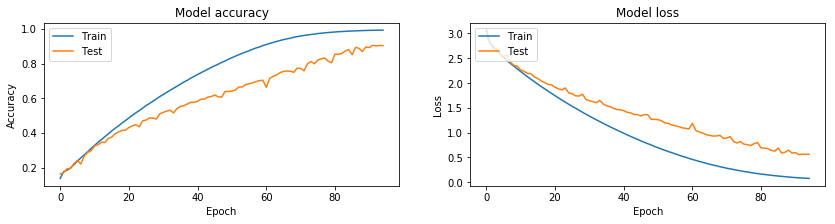

In [0]:
from matplotlib import pyplot as plt
# Plot training & validation accuracy values
plt.figure(figsize=(14,3))
plt.subplot(1, 2, 1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

files.download('Sezen-Aksu-Epoch_95-Acc_0.99-Val_Acc_0.90.hdf5')

In [0]:
# model ağırlıklarının yüklenmesi :
wights_file = 'Sezen-Aksu-Epoch_95-Acc_0.99-Val_Acc_0.90.hdf5' 
model.load_weights(wights_file)
model.compile(loss = 'categorical_crossentropy', optimizer = adam)

In [0]:
# rastgele bir şarkı öbeği seç:
start = np.random.randint(0, len(data_X)-1)
pattern = data_X[start]
print('Seçilen söz : ')
print("\"",''.join([int_chars[value] for value in pattern]), "\"\n")
# karakter olarak oluşturulmak istenen şarkı uunluğu
generated_characters = 300
# karakter üret:
for i in range(generated_characters):
    x = np.reshape(pattern, ( 1, len(pattern), 1))
    x = x / float(n_vocab)
    prediction = model.predict(x,verbose = 0)
    index = np.argmax(prediction)
    result = int_chars[index]
    sys.stdout.write(result)
    pattern.append(index)
    pattern = pattern[1:len(pattern)]
print('\nBitti')

Seçilen söz : 
" ler var
gitme dur daha şimdiden  "

deliler gibi özledim
i̇kimiz içinde doğru olan böylesi git
i̇nan bana sandığın kadar bile haçırım var
van yaylar
hayırsıl tüsü dklerin dükülden girki gelen kardığınmeyin
bereen o çücül tür gelme
teni gördüm uan
bir dünya bir tırd gön eelir
yat oomadak tenenen aşkın oldum dilere gamiı yon
yuruş malpi
Bitti


In [0]:
!pip install -q textgenrnn
from google.colab import files
from textgenrnn import textgenrnn
import os

In [0]:
# colab:
uploaded = files.upload()
all_files = [(name, os.path.getmtime(name)) for name in os.listdir()]
file_path = sorted(all_files, key=lambda x: -x[1])[0][0]
# lokal:
#file_path='Sezen Aksu Only Lyrics.csv'

In [0]:
model_name = 'Sezen_Aksu_textgenrnn_Model'

textgen = textgenrnn(name=model_name)
train_function = textgen.train_from_file if train_cfg['line_delimited'] else textgen.train_from_largetext_file
train_function(
    file_path=,file_path
    new_model=True,
    num_epochs=100,
    gen_epochs=25,
    batch_size=1024,
    train_size=0.9,
    dropout=0.5,
    max_gen_length=300,
    validation=True,
    is_csv=False,
    rnn_layers=4,
    rnn_size=32,
    rnn_bidirectional=True,
    max_length=15,
    dim_embeddings=100,
    word_level=False)

12,125 texts collected.
Training new model w/ 4-layer, 32-cell Bidirectional LSTMs
Training on 307,386 character sequences.
Epoch 1/100
300/300 [==============================] - 28s 94ms/step - loss: 2.3329 - val_loss: 2.0181
Epoch 2/100
300/300 [==============================] - 27s 90ms/step - loss: 1.9702 - val_loss: 1.8434
Epoch 3/100
300/300 [==============================] - 27s 89ms/step - loss: 1.8227 - val_loss: 1.7378
Epoch 4/100
300/300 [==============================] - 26s 86ms/step - loss: 1.7242 - val_loss: 1.6548
Epoch 5/100
300/300 [==============================] - 25s 84ms/step - loss: 1.6622 - val_loss: 1.6111
Epoch 6/100
300/300 [==============================] - 25s 82ms/step - loss: 1.6084 - val_loss: 1.5779
Epoch 7/100
300/300 [==============================] - 27s 91ms/step - loss: 1.5716 - val_loss: 1.5392
Epoch 8/100
300/300 [==============================] - 25s 83ms/step - loss: 1.5371 - val_loss: 1.5203
Epoch 9/100
300/300 [==============================]

300/300 [==============================] - 24s 81ms/step - loss: 0.9737 - val_loss: 1.1283
Epoch 70/100
300/300 [==============================] - 24s 80ms/step - loss: 0.9720 - val_loss: 1.1356
Epoch 71/100
300/300 [==============================] - 24s 81ms/step - loss: 0.9650 - val_loss: 1.1256
Epoch 72/100
300/300 [==============================] - 24s 80ms/step - loss: 0.9636 - val_loss: 1.1338
Epoch 73/100
300/300 [==============================] - 24s 80ms/step - loss: 0.9565 - val_loss: 1.1188
Epoch 74/100
300/300 [==============================] - 25s 84ms/step - loss: 0.9545 - val_loss: 1.1203
Epoch 75/100
300/300 [==============================] - 24s 81ms/step - loss: 0.9501 - val_loss: 1.1198
####################
Temperature: 0.2
####################
"ne olur kalp kavuşmakta sen dayanırsın

"ne olur kapıyı

"ne olur kalp kavuşmakta sen dayanırsın

####################
Temperature: 0.5
####################
"lk gün gibi, ilk gün gibi saklarını

"lk gün gibi, ilk gün gibi sen

In [0]:
print(textgen.model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 15)           0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 15, 100)      6200        input[0][0]                      
__________________________________________________________________________________________________
dropout (SpatialDropout1D)      (None, 15, 100)      0           embedding[0][0]                  
__________________________________________________________________________________________________
rnn_1 (Bidirectional)           (None, 15, 64)       34304       dropout[0][0]                    
__________________________________________________________________________________________________
rnn_2 (Bid

In [0]:
files.download('{}_weights.hdf5'.format(model_name))
files.download('{}_vocab.json'.format(model_name))
files.download('{}_config.json'.format(model_name))

NameError: name 'files' is not defined

In [0]:
textgen = textgenrnn(weights_path='Sezen_Aksu_textgenrnn_Model_weights.hdf5',
                       vocab_path='Sezen_Aksu_textgenrnn_Model_vocab.json',
                       config_path='Sezen_Aksu_textgenrnn_Model_config.json')
generated_characters = 300
textgen.generate_samples(15)
textgen.generate_to_file('lyrics.txt', 300)

####################
Temperature: 0.2
####################
"lk gün gibi, ilk gün gibi seni beklerim de gırtlak, pufidi kandil, tumba yatak"

"ne olur günahlarım yaşamak

"ne olur ki yıllarca yalan kattık

"nsan, sevgi kokuyorsun"

"ne olur kapılarıma

"ne olur kulağıma

"nerde saydım sevişler

"ne yana bi beni sarardı sana kapılarıma sarar ve dayanırsın

"ne yangınlar bir de ateşte

"nerde kalbim, aahh kalbim!"

"ne olur ki aşk için her gece günde

"ne olur bir kuş sanki

"nerde sevgili, bebekseyim"

"nsan, sevgi kokuyorsun"

"nsan, sevgi kokuyorsun"

####################
Temperature: 0.5
####################
"nsan, sevgi kokuyorsun"

"tevâş taşkın kısası

"ne hata tanımıyorum

"ne bana uyursa da şart değil demiştim

"lk gün gibi, ilk gün gibi seni bekler çek git bile yaşadığım

"titremem dar beni yak kim

"lk gün gibi, ilk gün gibi seni beklerim başlar günler gibi

"tara bu hal tuzak yüzünü uyudan mı aldım

"lale devri çocuklarım doğru büyük kalaşlar

"tek kırın gibi özlerimi

"tepeda

TypeError: generate_to_file() takes 2 positional arguments but 3 were given